In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# used for showing progess bar
from tqdm.auto import tqdm

import spacy
from spacy.lang.pl.examples import sentences 
from spacy.language import Language
# used for showing NER
from spacy import displacy

## Loading data

In [2]:
data = pd.read_csv("../data/stwierdzenia_nie_stwierdzenia.csv", encoding = "utf-8", names = ["is_statment", "text"], header=0)
data.head(3)

,is_statment,text
0,1,@Anna_Mierzynska @oko_press Efekty widać: szcz...
1,0,@iwonka5 Bo to jest od dziś. Wszystkie szczepi...
2,1,Szczepionka #Soberana02 weszła w ostatnią fazę...


In [3]:
print(data['text'][0])

@Anna_Mierzynska @oko_press Efekty widać: szczepienia trwają od grudnia, głównie jedna dawka, dopiero niedawno zaczęło się masowe podawanie drugiej. Na pocz stycznia było tu nawet 60 tys zakażeń dziennie, wczoraj było 4700. A robią od 600 tys do blisko miliona testów dziennie.


## Dataset exploration

In [4]:
data.value_counts('is_statment')

is_statment
0    4430
1    1960
dtype: int64

<AxesSubplot:xlabel='is_statment', ylabel='count'>

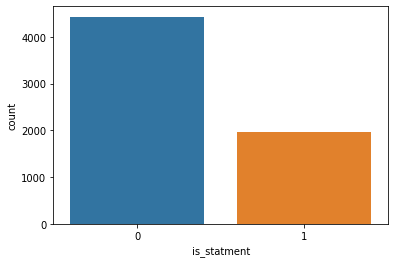

In [5]:
sns.countplot(x = "is_statment", data = data)

## Text preprocessing & cleaning

In [6]:
# load spacy model with binaries and configuration information
nlp = spacy.load("pl_core_news_lg")

In [7]:
import re
from unidecode import unidecode

def to_lowercase(text):
    return text.lower()

# TODO decision based on the fact that model is trained with using polish signs
# def unidecode_text(text):
#     return unidecode(text)

pl_stopwords = set(open("../data/pl_stopwords.txt", encoding="utf-8", mode='r').read().split("\n"))
def remove_stopwords(text, stopwords = pl_stopwords):
    return ' '.join([word for word in text.split(" ") if word not in stopwords])
    
def remove_mentions(text):
    return re.sub(r'\B\@([\w\-]+)','', text)    

def remove_hashtags(text):
    return re.sub(r'\B\#([\w\-]+)','', text)    

def remove_urls(text):
    return re.sub(r'http\S+','', text)    

def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

# TODO in the future as emojis can deliver a lot of important informations
# def emojis_to_words(text):
#     return text

def remove_punctuation(text):
    return re.sub(r'[^\w\s]','', text)    

def remove_numbers(text):
    return re.sub(r' \d+','', text)    

def remove_n_lenght_words(text, n = 1):
    return ' '.join([word for word in text.split(" ") if len(word) > n])

def remove_duplicated_spaces(text):
    return " ".join(text.split())

def preprocess_text(text):
    text = to_lowercase(text)
#     text = unidecode_text(text)
#     text = remove_stopwords(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_urls(text)
    text = remove_emojis(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_n_lenght_words(text)
    text = remove_duplicated_spaces(text)
    return text

In [8]:
test_text = "@Anna_Mierzynska @oko_press Efekty https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95 widać: szczepienia trwają od grudnia, głównie jedna dawka, dopiero niedawno zaczęło się masowe podawanie drugiej. Na pocz stycznia było tu nawet 60 tys zakażeń #non_stop #stopnop dziennie, wczoraj było 4700. 😁 A robią od 600 tys do blisko miliona testów dziennie."
preprocess_text(test_text)

'efekty widać szczepienia trwają od grudnia głównie jedna dawka dopiero niedawno zaczęło się masowe podawanie drugiej na pocz stycznia było tu nawet tys zakażeń dziennie wczoraj było robią od tys do blisko miliona testów dziennie'

In [9]:
# apply text cleaning functions
data['text'] = data['text'].apply(lambda text: preprocess_text(text))

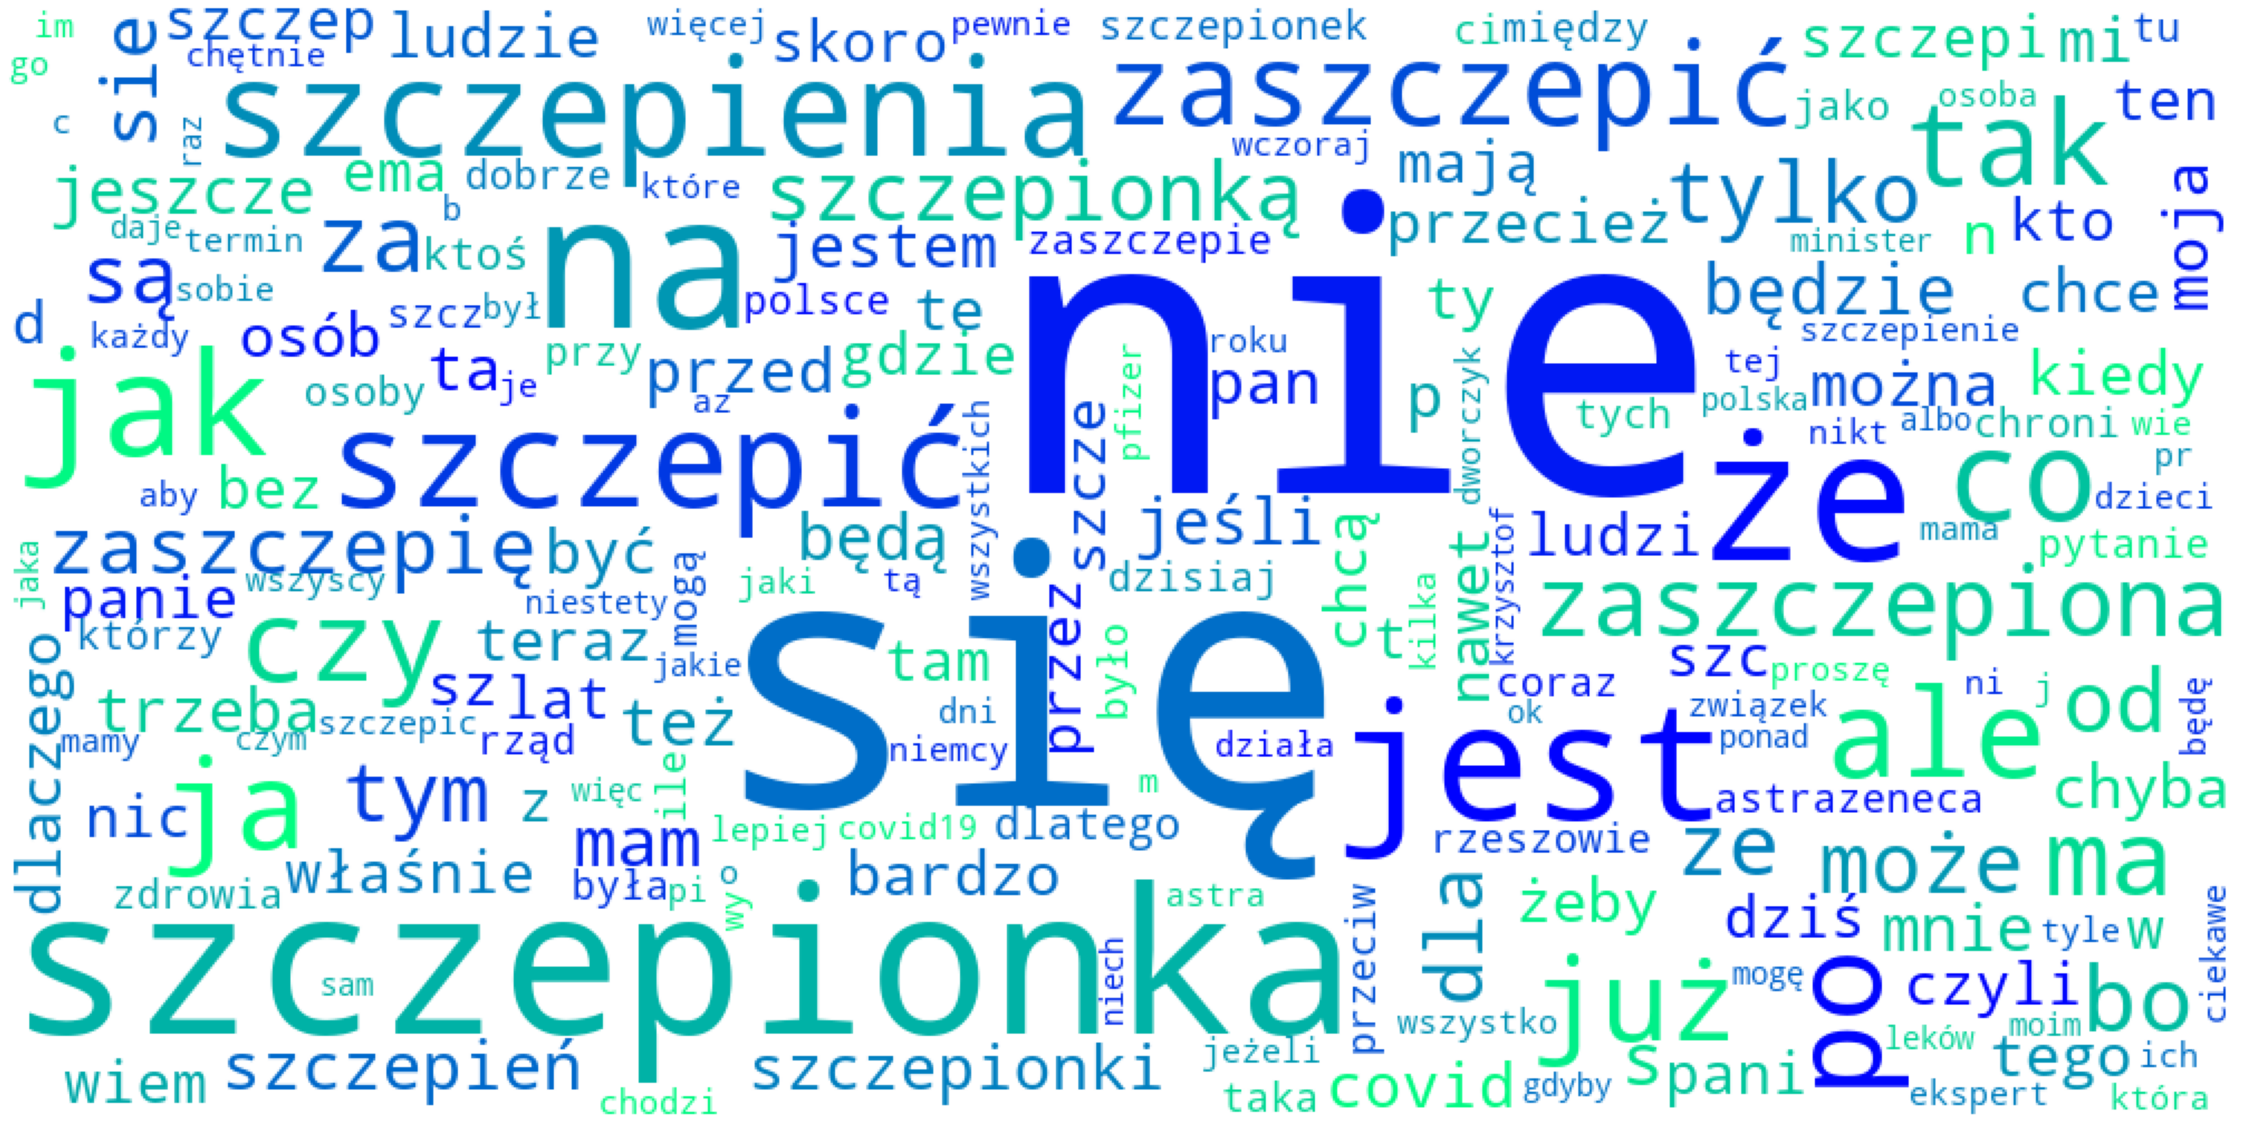

In [11]:
# from wordcloud import WordCloud

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 1000, height = 500, random_state=1, background_color='white', colormap='winter', collocations=False).generate(data['text'].to_string())

plot_cloud(wordcloud)

## Using spaCy NLP model and doing train-test split

In [208]:
docs = list(nlp.pipe(data['text']))

In [209]:
print(docs[0])
print(docs[0].vector.shape)

efekty widać szczepienia trwają od grudnia głównie jedna dawka dopiero niedawno zaczęło się masowe podawanie drugiej na pocz stycznia było tu nawet tys zakażeń dziennie wczoraj było robią od tys do blisko miliona testów dziennie
(300,)


In [223]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = np.array([doc.vector for doc in docs])
y = data['is_statment']

In [224]:
print(X.shape)
print(y.shape)

(6390, 300)
(6390,)


In [225]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

## Logistic classification

In [227]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

# TODO Implement grid search
# logistic_model_param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2'],
#     'max_iter': list(range(100,800,100)),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }

# logistic_model_search = GridSearchCV(logistic_model, param_grid=logistic_model_param_grid, refit = True, verbose = 1, cv=5)

# Creating logistic regression model and fiting to training data using grid search
logistic_model.fit(X_train , y_train)
# logistic_model_search.best_params_

# Summarize
# print(f'Mean Accuracy: {logistic_model_search.best_score_}')
# print(f'Config: {logistic_model_search.best_params_}')

c:\users\kubas\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [228]:
from sklearn import metrics

predictions = logistic_model.predict(X_test)
probabilities = logistic_model.predict_proba(X_test)

Logistic Regression Accuracy: 0.7486960644855382
Logistic Regression Precision: 0.6053215077605322
Logistic Regression Recall: 0.4368


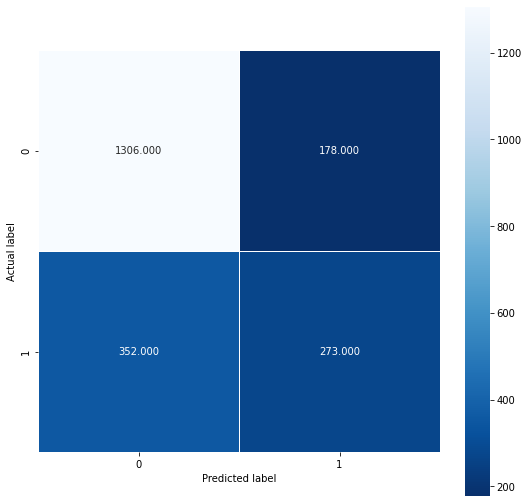

In [229]:
# Showing different measuserments
print(f'Logistic Regression Accuracy: {metrics.accuracy_score(y_test, predictions)}')
print(f'Logistic Regression Precision: {metrics.precision_score(y_test, predictions)}')
print(f'Logistic Regression Recall: {metrics.recall_score(y_test, predictions)}')

# Confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

c:\users\kubas\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


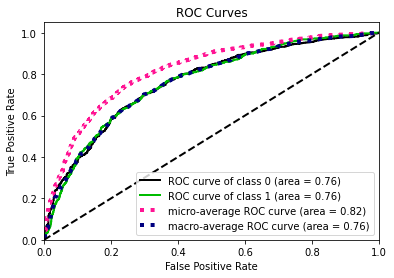

In [230]:
# Generating ROC Curve
import scikitplot as skplt

skplt.metrics.plot_roc_curve(y_test, probabilities)
plt.show()

## Support Vector Machine

In [235]:
from sklearn.svm import SVC

# TODO Implement grid search nad optimize
support_vector_machine_model = SVC(probability=True)
support_vector_machine_model.fit(X_train , y_train)

SVC(probability=True)

In [236]:
predictions = support_vector_machine_model.predict(X_test)
probabilities = support_vector_machine_model.predict_proba(X_test)

Logistic Regression Accuracy: 0.766239924134661
Logistic Regression Precision: 0.7024539877300614
Logistic Regression Recall: 0.3664


Text(0.5, 103.73999999999997, 'Predicted label')

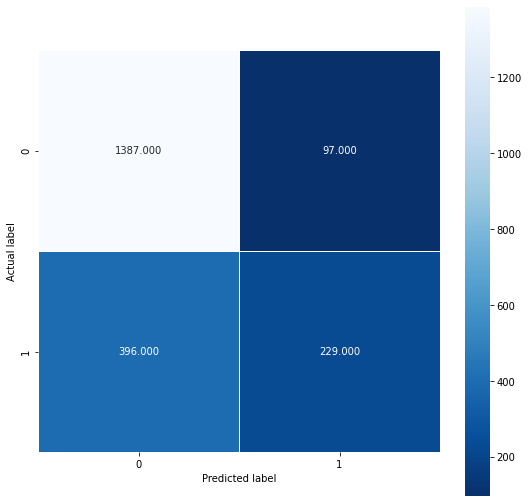

In [237]:
# Showing different measuserments
print(f'Logistic Regression Accuracy: {metrics.accuracy_score(y_test, predictions)}')
print(f'Logistic Regression Precision: {metrics.precision_score(y_test, predictions)}')
print(f'Logistic Regression Recall: {metrics.recall_score(y_test, predictions)}')

# Confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

c:\users\kubas\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


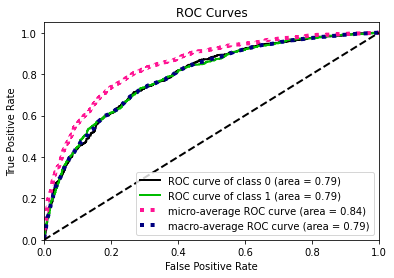

In [238]:
skplt.metrics.plot_roc_curve(y_test, probabilities)
plt.show()

## Random forest

In [247]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train , y_train)

RandomForestClassifier()

In [248]:
predictions = random_forest_model.predict(X_test)
probabilities = random_forest_model.predict_proba(X_test)

Logistic Regression Accuracy: 0.7501185395922239
Logistic Regression Precision: 0.675
Logistic Regression Recall: 0.3024


Text(0.5, 103.73999999999997, 'Predicted label')

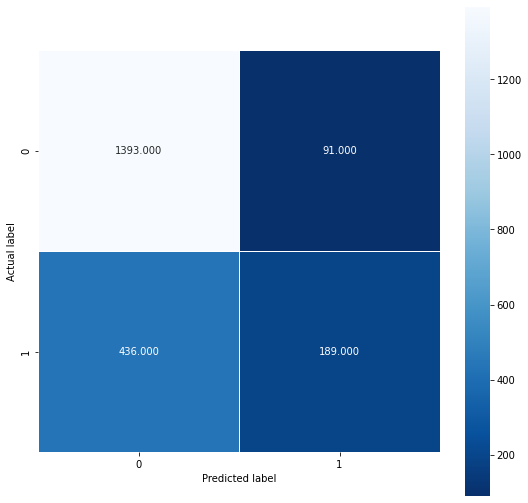

In [249]:
# Showing different measuserments
print(f'Logistic Regression Accuracy: {metrics.accuracy_score(y_test, predictions)}')
print(f'Logistic Regression Precision: {metrics.precision_score(y_test, predictions)}')
print(f'Logistic Regression Recall: {metrics.recall_score(y_test, predictions)}')

# Confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

c:\users\kubas\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


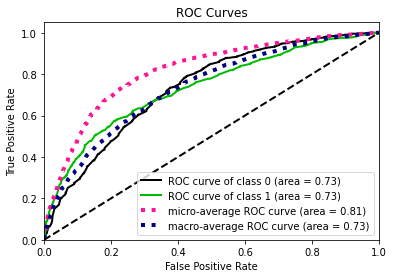

In [250]:
skplt.metrics.plot_roc_curve(y_test, probabilities)
plt.show()

In [251]:
# TODO Add functions that compare results
# TODO Add more optimization functions and do more hyper params tunning
# TODO Exporting binaries and writining simple function that excepts text and outoputs probailites
# TODO Implement CNN
# TODO Pack preprocessing process in pipipline 
# TODO Add requirments.txt file